In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from numpy import interp

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

In [5]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/'
                 'breast-cancer-wisconsin/wdbc.data', header=None)

In [9]:
# DF first column is sample ID, second column is class (M = malignant, B = benign),
# and third forward columns are features
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [10]:
le.transform(['M', 'B'])

array([1, 0])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [15]:
# Creates a pipeline which streamlines all preprocessing steps and the
# model training to avoid the trouble of repeating this process manually
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


In [16]:
# Holdout method

# Splits the test set into two separate datasets. Use one set for model selection 
# (hyperparameter tuning) and the other set for final performance evaluation. This 
# helps reduce the bias of using a single test set to "train" the hyperparameters.

# The sets are usually referred as training, validation/development, and test datasets.
# Training: used to fit the model
# Validation: used to select hyperparameters
# Test: user to get an unbiased generalization metric

In [20]:
# K-fold cross-validation

# K-folds aims to be more robust than holdout by better partitioning the train set.
# Training set is split in k-1 folds, and one fold is used for test. The process is
# repeated k times to end up with k models and k performance estimates. After selecting
# the best performant model hyperparams, it's retrained on the whole training set.
# Stratified k-fold improves the distribution of sample classes across different folds.
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold {k + 1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold 01, Class distr.: [256 153], Acc.: 0.935
Fold 02, Class distr.: [256 153], Acc.: 0.935
Fold 03, Class distr.: [256 153], Acc.: 0.957
Fold 04, Class distr.: [256 153], Acc.: 0.957
Fold 05, Class distr.: [256 153], Acc.: 0.935
Fold 06, Class distr.: [257 153], Acc.: 0.956
Fold 07, Class distr.: [257 153], Acc.: 0.978
Fold 08, Class distr.: [257 153], Acc.: 0.933
Fold 09, Class distr.: [257 153], Acc.: 0.956
Fold 10, Class distr.: [257 153], Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


In [24]:
# SKLearn cross-validation (CV) implementation
# n_jobs distributes evaluation in n CPUs
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print(f'CV accuracy scores: {scores}')
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


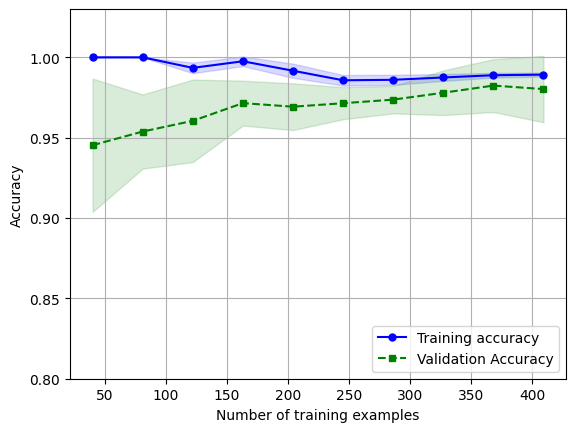

In [29]:
# Learning Curves help diagnose if algorithms are overfitting (high variance) 
# or underfitting (high bias). We analyze train and test accuracy as a function
# of the number of the examples.
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

# kfold (cv param) = 10
# train_sizes are relative factors, here it's [0.1, 0.2, ..., 0.9, 1.0]
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1,
                   train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

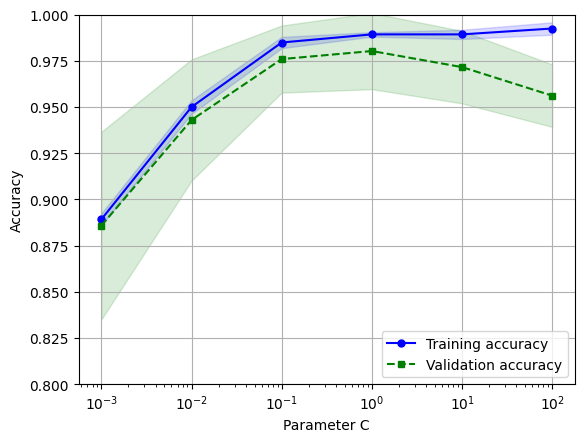

In [31]:
# Validation curves, they work similar to learning curve, but instead of evaluating 
# performance as a function of number of examples, it evaluates performance as a 
# function of a hyperparameter, e.g.: the regularization C.
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# By default, uses stratified k-fold for the classes, as learning curve.
# C is the inverse regularization, smaller C tend to increase regularization effect.
# Smaller C = underfitting, Larger C = overfitting
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train, y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()
# From this plot we can see the honey pot sits around 10^-1 where we get maximum
# low bias (high training accuracy) and low variance (diff between training and 
# validation accuracy).

In [38]:
# Using grid search to find optimal combination of parameter values.
# This examples uses Support Vector Machine which has more params.
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]

# GridSearchCV uses k-fold cross-validation (cv = 10 is the number of k-folds).
# n_jobs = -1 instructs grid search to use the maximum number of CPUs
# Refit=True instructs grid search to retrain the best model on the whole training set.
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print('Best score: ', gs.best_score_)
print('Best params: ', gs.best_params_)

# Getting the best estimator from GridSearchCV output
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Best score:  0.9846859903381642
Best params:  {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy: 0.974


In [49]:
# GridSearchCV is guaranteed to find the best hyperparameters for the given input
# because it runs exhaustive search, however it's computationally expensive. To 
# handle extensive params space, random search is an alternative.

# Instead of using discrete lists of parameter values, for random search we pass a
# distribution of values which will be used to draw random values. LogUniform
# distribution guarantees that the same number of params will be drawn from the ranges
# [0.0001, 0.001] and [10.0, 100.0].
param_range = scipy.stats.loguniform(0.0001, 1000.0)

# Drawing some samples
np.random.seed(1)
print(param_range.rvs(10))

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True, n_iter=20, cv=10,
                        random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)
print('Best score: ', rs.best_score_)
print('Best params: ', rs.best_params_)

[8.30145146e-02 1.10222804e+01 1.00184520e-04 1.30715777e-02
 1.06485687e-03 4.42965766e-04 2.01289666e-03 2.62376594e-02
 5.98924832e-02 5.91176467e-01]
Best score:  0.9780676328502416
Best params:  {'svc__C': 0.05971247755848463, 'svc__kernel': 'linear'}


In [52]:
# Another technique is called successive halving, which start by training a bigger
# number of models with smaller training dataset to save on resources, then based
# on the scores pick the best 50% and double the training set size. Repeat this 
# process until only a single best hyperparameter is selected.
hs = HalvingRandomSearchCV(pipe_svc,
                           param_distributions=param_grid,
                           n_candidates='exhaust',
                           # Specifies training set as the resource to vary between rounds
                           resource='n_samples',
                           # How many are eliminated each round (66% make to next one)
                           factor=1.5,
                           random_state=1,
                           n_jobs=-1)

hs = hs.fit(X_train, y_train)
print('Best score: ', hs.best_score_)
print('Best params: ', hs.best_params_)

# Estimate on test set
clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

Best score:  0.9617647058823529
Best params:  {'svc__C': 4.934834261073333, 'svc__kernel': 'linear'}
Test accuracy: 0.982


In [57]:
# Nested Cross Validation example for SVM
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}]
# Inner loop
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
# Outer loop
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'SVM CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

# Comparing SVM against DecisionTree using Nested Cross Validation
# Inner loop
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
# Outer loop
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'Tree CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

# We can see that SVM is better predictor for this data distribution than DecisionTree

SVM CV accuracy: 0.974 +/- 0.015
Tree CV accuracy: 0.934 +/- 0.016


# Metrics

[[71  1]
 [ 2 40]]


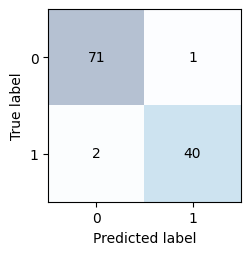

In [65]:
# Confusion matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_mat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
# Model correctly classified 71 TN and 40 TP.
# Model wrongly classified 2 FN and 1 FP.

In [70]:
# Error (ERR) and Accuracy (ACC)
# ERR = sum of all false predictions over all predictions
# ACC = sum of all true predictions over all predictions (1 - ERR)

# Recall (REC) and Precision (PRE)
# REC = how many of the true positives were classified as such
# PRE = how many of the predicted positives are really positives

# Optimizing for REC de-optimize for PRE, and vice-versa. To balance 
# both metrics F1 score is used, which is the harmonic mean of both metrics.

pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943


In [73]:
# Using a different custom metric with grid search
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs = gs.fit(X_train, y_train)
print('Best score: ', gs.best_score_)
print('Best params: ', gs.best_params_)

Best score:  0.9861994953378878
Best params:  {'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


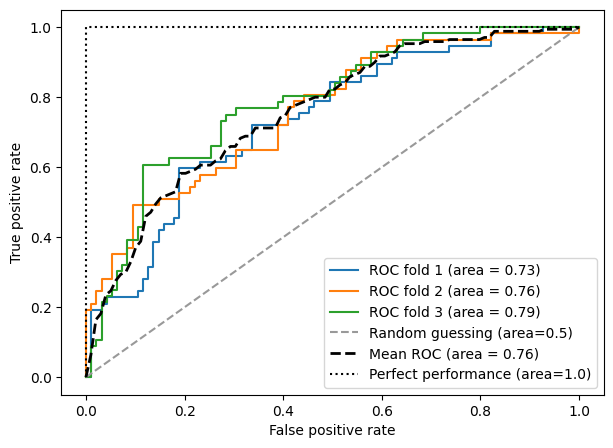

In [79]:
# Plotting a Received Operating Characteristic (ROC) curve. This takes in consideration
# the False Positive Rate and True Positive Rate. A diagonal line can be understood as
# random guess, and below diagonal are worse than random guess. A perfect graph would fall
# on top left, with 1 TPR and 0 FPR.

# Use less features to make prediction harder
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', C=100.0))
X_train2 = X_train[:, [4, 14]]  # Select two features only
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr) # Area under curve
    plt.plot(fpr, tpr, label=f'ROC fold {i + 1} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing (area=0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black',
         label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Metrics for multi-class systems
# Micro-average: useful if you want to weight each instance/prediction equally 
# Macro-average: useful if you want to weight each class equally
# Weight macro-average: each class is weighted based on the number of samples
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

In [84]:
# Dealing with class imbalances (THIS IS IMPORTANT)

# Creates an imbalanced dataset
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

# In this dataset, if we only predict benign (class 0) we achieve no-sense 90% accuracy
y_pred = np.zeros(y_imb.shape[0])
print("Imbalanced fixed prediction: ", np.mean(y_pred == y_imb) * 100)

# Up-sample more examples from the minority class to balance the training
print('Number of class 1 examples before: ',  X_imb[y_imb == 1].shape[0])
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], 
                                    y_imb[y_imb == 1],
                                    replace=True, 
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)
print('Number of class 1 examples after:', X_upsampled.shape[0])

# Then after resampling we can concatenate the minority class with the majority class
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

# Now the previous fixed model will lower accuracy as expected
y_pred = np.zeros(y_bal.shape[0])
print("Balanced fixed prediction: ", np.mean(y_pred == y_bal) * 100)

Imbalanced fixed prediction:  89.92443324937027
Number of class 1 examples before:  40
Number of class 1 examples after: 357
Balanced fixed prediction:  50.0
